In [1]:
import sys

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np
import pyximport
from gammapy.modeling import Fit, Parameter, Parameters
from gammapy.modeling.models import Models

This is a test
loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
from matplotlib import rc

sys.path.append("../")
import Dataset_load  # noqa: E402
from Dataset_Creation import sys_dataset  # noqa: E402

rc("font", **{"family": "serif", "serif": ["Computer Modern"]})
rc("text", usetex=True)
pyximport.install()

In [4]:
config = Dataset_load.load_config()
colors = config["colors"]["one"]

## Read dataset

In [5]:

scaled_amplitude = Parameter("amplitude", value=1e-12)
dataset_asimov = Dataset_load.create_asimov(
    model="pl", source="PKSflare", parameters=Parameters([scaled_amplitude])
)

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-pl.fits.gz


Varying the Exposure

In [6]:
savefig = True
picformat = "png"

shift = 0.1
tilt = 0.02
print(tilt)

0.02


In [7]:


sys_ = sys_dataset(
    dataset_asimov=dataset_asimov,
    shift=0,
    tilt=0,
    bias=0,
    resolution=0,
    rnd=False,
    e_reco_creation=10,
)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
# addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
# 'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(
    penalising_invcovmatrix,
    [1 / zero**2, 1 / zero**2, 1 / shift**2, 1 / tilt**2],
)
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix

npred_edisp
npred_edisp


In [8]:
%%time
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_asimov])

CPU times: user 25 s, sys: 6.5 s, total: 31.5 s
Wall time: 31 s


In [9]:
%%time
fitting = 0
if fitting:
    fit_cor_N = Fit(store_trace=False)
    result_cor = fit_cor_N.run([dataset_asimov_N])
else:
    dataset_asimov_N.models = Models.read("data/2_model_nui_0.0_tilt_0.yml")

CPU times: user 23.6 ms, sys: 4.38 ms, total: 27.9 ms
Wall time: 27.7 ms


In [10]:
dataset_asimov_N.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.2991e+00,,5.006e-02,nan,nan,False,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,1.230e-13,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,


In [11]:
dataset_asimov_N.models[-1].parameters["norm_nuisance"].frozen = True
dataset_asimov_N.models[-1].parameters["tilt_nuisance"].frozen = True

In [12]:
dataset_asimov.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.2990e+00,,4.634e-02,nan,nan,False,False,False,
spectral,amplitude,1.0002e-12,cm-2 s-1 TeV-1,5.059e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,


In [13]:
dataset_asimov_N.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.2991e+00,,5.006e-02,nan,nan,False,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,1.230e-13,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,


### Import Rnd

In [14]:
infos = np.loadtxt("data/7a_P_draw_info.txt")
pars = np.loadtxt("data/7a_P_draw_par.txt")
flux = np.loadtxt("data/7a_P_draw_flux.txt")
flux2e = np.loadtxt("data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)
shift_rnds = infos[:N_max, 0]
index_rnds = infos[:N_max, 1]
stat_sums = infos[:N_max, 2]


# amplitude', 'index', 'norm', 'tilt
amplitudes = pars[:N_max, 0:2]
indices = pars[:N_max, 2:4]
norms = pars[:N_max, 4:6]
tilts = pars[:N_max, 6:8]

692


In [15]:
len(flux[0])

20

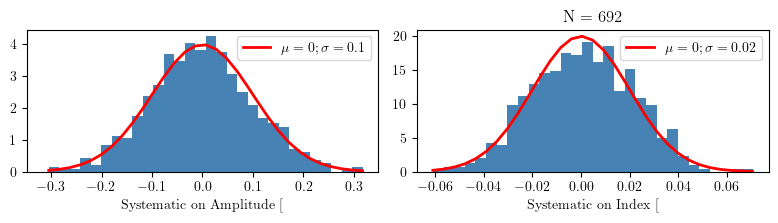

In [16]:
fig, (axs, ax1) = plt.subplots(1, 2, figsize=(2 * 4, 7 / 3))
nbins = 30
count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color="steelblue")
sigma = shift
mu = 0
axs.plot(
    bins,
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
    linewidth=2,
    color="r",
    label=f"$\\mu = {mu}; \\sigma = {sigma}$",
)

axs.set_xlabel("Systematic on Amplitude [%]")
axs.legend()

x = axs.get_xlim()
deltax = np.max([mu - x[0], x[1] - mu])
axs.set_xlim(mu - deltax, mu + deltax)


count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color="steelblue")
sigma = tilt
mu = 0
ax1.plot(
    bins,
    1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((bins - mu) ** 2) / (2 * sigma**2)),
    linewidth=2,
    color="r",
    label=f"$\\mu = {mu}; \\sigma = {sigma:.3}$",
)

ax1.set_xlabel("Systematic on Index [%]")
ax1.set_title(f"N = {N}")
ax1.legend()

x = axs.get_xlim()
deltax = np.max([mu - x[0], x[1] - mu])
axs.set_xlim(mu - deltax, mu + deltax)
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_rnd_sys_{shift}." + picformat)

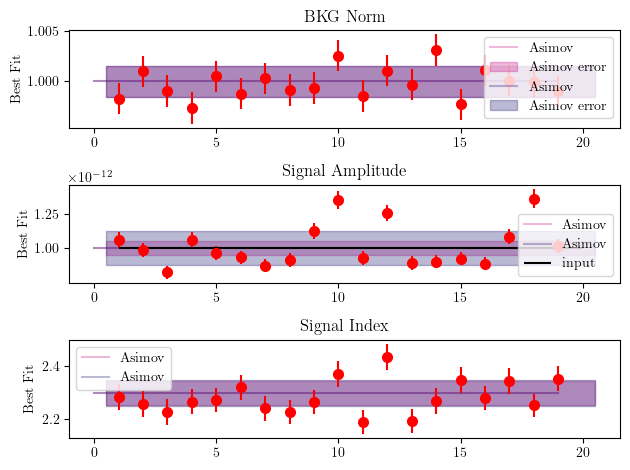

In [17]:
fig, axs = plt.subplots(3, 1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Amplitude")
axs[2].set_title("Signal Index")

N_plot = 20
labels = ["-10%", "0%", "10%"]


for i, d in enumerate([dataset_asimov, dataset_asimov_N]):
    best = d.models[1].parameters["norm"].value
    er = d.models[1].parameters["norm"].error
    axs[0].plot([best] * N_plot, color=colors[i], alpha=0.3, label="Asimov")
    axs[0].fill_betweenx(
        [best - er, best + er],
        0.5,
        N_plot + 0.5,
        color=colors[i],
        alpha=0.3,
        label="Asimov error",
    )

    best = d.models[0].parameters["amplitude"].value
    er = d.models[0].parameters["amplitude"].error
    axs[1].fill_betweenx(
        [best - er, best + er], 0.5, N_plot + 0.5, color=colors[i], alpha=0.3
    )
    axs[1].plot([best] * N_plot, color=colors[i], alpha=0.3, label="Asimov")

    best = d.models[0].parameters["index"].value
    er = d.models[0].parameters["index"].error
    axs[2].fill_betweenx(
        [best - er, best + er], 0.5, N_plot + 0.5, color=colors[i], alpha=0.3
    )
    axs[2].plot([best] * N_plot, color=colors[i], alpha=0.3, label="Asimov")

for i, a in enumerate(norms[1:N_plot]):
    axs[0].errorbar(x=i + 1, y=a[0], yerr=a[1], fmt="o", color="red", markersize=7)
# axs[0].hlines( norms[0][0], 1, N, label = "input", color = 'black')


for i, a in enumerate(amplitudes[1:N_plot]):
    axs[1].errorbar(x=i + 1, y=a[0], yerr=a[1], fmt="o", color="red", markersize=7)
axs[1].hlines(1e-12, 1, N_plot, label="input", color="black")


for i, a in enumerate(indices[1:N_plot]):
    axs[2].errorbar(x=i + 1, y=a[0], yerr=a[1], fmt="o", color="red", markersize=7)
# axs[2].hlines( indices[0][0], 1, N, label = "input", color ='black')


plt.tight_layout()
for a in axs:
    a.legend()
    a.set_ylabel("Best Fit")

plt.tight_layout()
# if savefig:
#    fig.savefig(f"plots/7b_best_fit_{factor}_{N}.pdf")

In [23]:

valuies = [norms, amplitudes, indices]

valuies_asimov = [
    [
        dataset_asimov.models[1].parameters["norm"].value,
        dataset_asimov.models[1].parameters["norm"].error,
    ],
    [
        dataset_asimov.models[0].parameters["amplitude"].value,
        dataset_asimov.models[0].parameters["amplitude"].error,
    ],
    [
        dataset_asimov.models[0].parameters["index"].value,
        dataset_asimov.models[0].parameters["index"].error,
    ],
]


valuies_asimov_N = [
    [
        dataset_asimov_N.models[1].parameters["norm"].value,
        dataset_asimov_N.models[1].parameters["norm"].error,
    ],
    [
        dataset_asimov_N.models[0].parameters["amplitude"].value,
        dataset_asimov_N.models[0].parameters["amplitude"].error,
    ],
    [
        dataset_asimov_N.models[0].parameters["index"].value,
        dataset_asimov_N.models[0].parameters["index"].error,
    ],
]
is_within_norm = []
is_within_amplitude = []
is_within_index = []
is_within_norm_N = []
is_within_amplitude_N = []
is_within_index_N = []

i = 0
for n in norms:
    larger = np.all(n[0] >= (valuies_asimov[0][0] - valuies_asimov[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov[0][0] + valuies_asimov[0][1]))
    is_within_norm.append(larger and smaller)

    larger = np.all(n[0] >= (valuies_asimov_N[0][0] - valuies_asimov_N[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov_N[0][0] + valuies_asimov_N[0][1]))
    is_within_norm_N.append(larger and smaller)

for a in amplitudes:
    larger = np.all(a[0] >= (valuies_asimov[1][0] - valuies_asimov[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov[1][0] + valuies_asimov[1][1]))
    is_within_amplitude.append(larger and smaller)

    larger = np.all(a[0] >= (valuies_asimov_N[1][0] - valuies_asimov_N[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov_N[1][0] + valuies_asimov_N[1][1]))
    is_within_amplitude_N.append(larger and smaller)

for i in indices:
    larger = np.all(i[0] >= (valuies_asimov[2][0] - valuies_asimov[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov[2][0] + valuies_asimov[2][1]))
    is_within_index.append(larger and smaller)

    larger = np.all(i[0] >= (valuies_asimov_N[2][0] - valuies_asimov_N[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov_N[2][0] + valuies_asimov_N[2][1]))
    is_within_index_N.append(larger and smaller)

within_norm = [
    np.count_nonzero(is_within_norm) / N,
    np.count_nonzero(is_within_norm_N) / N,
]

within_amplitude = [
    np.count_nonzero(is_within_amplitude) / N,
    np.count_nonzero(is_within_amplitude_N) / N,
]

within_index = [
    np.count_nonzero(is_within_index) / N,
    np.count_nonzero(is_within_index_N) / N,
]

withins = [within_norm, within_amplitude, within_index]

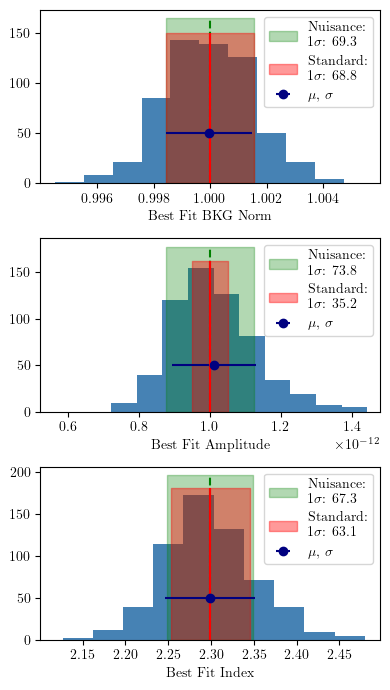

In [24]:
fig, axs = plt.subplots(3, 1, figsize=(4, 7))
xlabels = ["Best Fit BKG Norm", "Best Fit Amplitude", "Best Fit Index"]

axs[2].errorbar(
    x=np.mean(indices[:, 0]),
    y=50,
    xerr=np.std(indices[:, 0]),
    fmt="o",
    color="navy",
    label="$\\mu$, $\\sigma$",
)
axs[1].errorbar(
    x=np.mean(amplitudes[:, 0]),
    y=50,
    xerr=np.std(amplitudes[:, 0]),
    fmt="o",
    color="navy",
    label="$\\mu$, $\\sigma$",
)
axs[0].errorbar(
    x=np.mean(norms[:, 0]),
    y=50,
    xerr=np.std(norms[:, 0]),
    fmt="o",
    color="navy",
    label="$\\mu$, $\\sigma$",
)


for i, v in enumerate(valuies):
    axs[i].hist(v[1:, 0], color="steelblue")
    ylim = axs[i].get_ylim()
    delta_ylim = 15

    axs[i].vlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color="green",
        linestyle="dashed",
    )
    axs[i].fill_between(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=0.3,
        color="green",
        label=f"Nuisance: \n 1$\\sigma$: {withins[i][1]*100 :.3}%",
    )
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color="red")
    axs[i].fill_between(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=0.4,
        color="red",
        label=f"Standard: \n 1$\\sigma$: {withins[i][0]*100 :.3}%",
    )

    axs[i].legend(loc="upper right")
    axs[i].set_xlabel(xlabels[i])

    x = axs[i].get_xlim()
    deltax = np.max([valuies_asimov[i][0] - x[0], x[1] - valuies_asimov[i][0]])
    axs[i].set_xlim(valuies_asimov[i][0] - deltax, valuies_asimov[i][0] + deltax)


plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7b_histo_{shift}." + picformat)

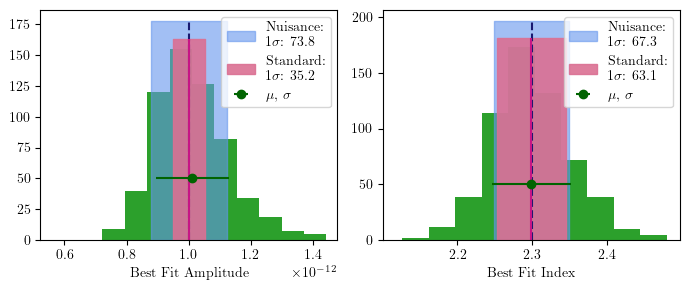

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
xlabels = ["Best Fit Amplitude", "Best Fit Index"]

axs[1].errorbar(
    x=np.mean(indices[:, 0]),
    y=50,
    xerr=np.std(indices[:, 0]),
    fmt="o",
    color="darkgreen",
    label="$\\mu$, $\\sigma$",
)
axs[0].errorbar(
    x=np.mean(amplitudes[:, 0]),
    y=50,
    xerr=np.std(amplitudes[:, 0]),
    fmt="o",
    color="darkgreen",
    label="$\\mu$, $\\sigma$",
)

i = 1
for p, v in enumerate(valuies[1:]):
    axs[p].hist(v[1:, 0], color="tab:green")
    ylim = axs[p].get_ylim()
    delta_ylim = 15

    axs[p].vlines(
        valuies_asimov_N[i][0],
        ylim[0],
        ylim[1] + delta_ylim,
        color=colors[1],
        linestyle="dashed",
    )
    axs[p].fill_between(
        [
            valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
            valuies_asimov_N[i][0] + valuies_asimov_N[i][1],
        ],
        ylim[0],
        ylim[1] + delta_ylim,
        alpha=0.6,
        color=colors[3],
        label=f"Nuisance: \n 1$\\sigma$: {withins[i][1]*100 :.3}%",
    )
    axs[p].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color=colors[0])
    axs[p].fill_between(
        [
            valuies_asimov[i][0] - valuies_asimov[i][1],
            valuies_asimov[i][0] + valuies_asimov[i][1],
        ],
        ylim[0],
        ylim[1],
        alpha=0.9,
        color=colors[2],
        label=f"Standard: \n 1$\\sigma$: {withins[i][0]*100 :.3}%",
    )

    axs[p].legend(loc="upper right")
    axs[p].set_xlabel(xlabels[p])

    x = axs[p].get_xlim()
    deltax = np.max([valuies_asimov[i][0] - x[0], x[1] - valuies_asimov[i][0]])
    axs[p].set_xlim(valuies_asimov[i][0] - deltax, valuies_asimov[i][0] + deltax)
    # axs[p].set_yscale('log')
    i += 1

plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7b_histo_{shift}." + picformat)

In [26]:
mask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1) > 0
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
asimov, asimov_errors = dataset_asimov.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_asimov_N.models[0].spectral_model.evaluate_error(
    ebins
)

In [27]:
withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]
        lowerlim = np.all(value <= asimov.value[ie] + asimov_errors.value[ie])
        upperlim = np.all(value >= asimov.value[ie] - asimov_errors.value[ie])
        x = lowerlim & upperlim
        xs.append(x)

        lowerlim = np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie])
        upperlim = np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie])
        x = lowerlim & upperlim
        xs_N.append(x)

    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)

In [28]:
mean = flux2e.mean(axis=0)
std = flux2e.std(axis=0)

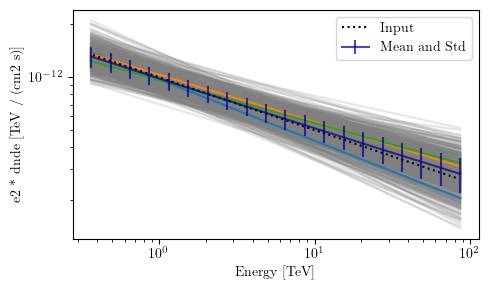

In [29]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0], ebins[-1]) * u.TeV
fig, axs = plt.subplots(1, 1, figsize=(5, 3))
for i, f in enumerate(flux2e):
    axs.plot(ebins, f, color="grey", alpha=0.2)  # 10/N)
for i, f in enumerate(flux2e[:3]):
    axs.plot(
        ebins,
        f,
    )
axs.errorbar(ebins, mean, yerr=std, color="darkblue", alpha=0.7, label="Mean and Std")

dataset_asimov.models[0].spectral_model.plot(
    energy_bounds,
    linestyle=":",
    energy_power=2,
    ax=axs,
    label="Input",
    color="black",
)
axs.legend()
axs.set_xlabel("Energy [TeV]")
plt.tight_layout()
# if savefig:
#    fig.savefig(f"plots/7b_rnd_spectra_{shift}_{N}." + picformat)

In [30]:
def compute_precision(N):
    Z = 1.645
    return Z / np.sqrt(N)

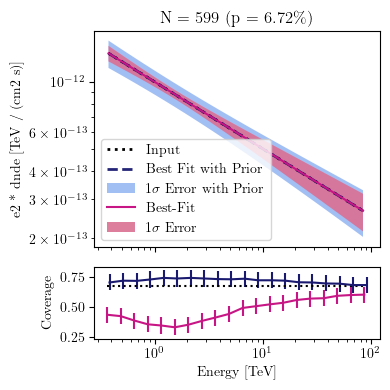

In [31]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0], ebins[-1]) * u.TeV
energy_power = 2
fig, (axs, ax2) = plt.subplots(
    2, 1, gridspec_kw={"height_ratios": [3, 1]}, sharex=True, figsize=((4, 4))
)
# axs.errorbar(ebins, mean, yerr = std,  color = 'darkblue', alpha = 0.7,
#            label = "Mean and Std")
dataset_asimov.models[0].spectral_model.plot(
    energy_bounds,
    energy_power=energy_power,
    ax=axs,
    label="Input",
    color="black",
    linewidth=energy_power,
    linestyle="dotted",
)
dataset_asimov_N.models[0].spectral_model.plot(
    energy_bounds,
    energy_power=energy_power,
    ax=axs,
    color=colors[1],
    label="Best Fit with Prior",
    alpha=0.95,
    linestyle="dashed",
    linewidth=2,
)
dataset_asimov_N.models[0].spectral_model.plot_error(
    energy_bounds,
    energy_power=energy_power,
    ax=axs,
    facecolor=colors[3],
    label="$1\\sigma$ Error with Prior",
    alpha=0.6,
)

dataset_asimov.models[0].spectral_model.plot(
    energy_bounds, energy_power=energy_power, ax=axs, label="Best-Fit", color=colors[0]
)
dataset_asimov.models[0].spectral_model.plot_error(
    energy_bounds,
    energy_power=energy_power,
    ax=axs,
    facecolor=colors[2],
    alpha=0.9,
    label="$1\\sigma$ Error",
)
p = compute_precision(N)
ax2.errorbar(ebins, withine, yerr=p, color=colors[0], label="")
ax2.errorbar(ebins * 1.05, withine_N, yerr=p, color=colors[1], label="")
ax2.plot(ebins, [0.68] * len(ebins), ":", color="black", label="")

axs.set_xlabel("")
axs.legend()
# ax2.legend(ncol = 2)
axs.set_title(f"N = {N} (p = {p*100:.3}\\%)")
ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel("Coverage")

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_spectra_{shift}." + picformat)
    fig.savefig(f"plots/7b_spectra_{shift}." + "pdf")